In [1]:
base_seed = 1300
n_seeds = 10

model_id = 'lv'
save_path = 'results/' + model_id

use_maf = False

noise_sd = 50.0  # compare to log(noise_sd) = 2.3 in Owen et al. 2014, Likelihood free inference for Makov Processes: a comparison

include_initial_state = True

# simulation setup
setup_opts = {        
    'n_hiddens': [50, 50],
    'reg_lambda': 0.01,
    'pilot_samples': 1000,
    'verbose': True,
    'prior_norm': False,    
    'svi': False,
    'n_rnn': 100,
    'n_inputs_rnn': 2
}

run_opts = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 100,
    'epochs': 2000,
    'moo': 'resample',
    'proposal': 'gaussian',
    'n_null': None,
    'train_on_all': True,
    'max_norm': 0.1,
    'val_frac': 0.1,
    'silent_fail': False,
    'reuse_prior_samples': True,
}
  
if run_opts['train_on_all']:
    run_opts['epochs'] = [run_opts['epochs'] // (r+1) for r in range(run_opts['n_rounds'])]

if use_maf:
    # control MAF seed
    rng_maf = np.random
    
    setup_opts.update({
        'mode': 'random',
        'n_mades': 5,
        'rng': rng_maf,
        'act_fun': 'tanh',
        'batch_norm': False
    })

pars_true = np.array([-4.60517019, -0.69314718,  0.        , -4.60517019])  # from SNL paper
#x0 was generated by simulation using the true parameters from the SNL paper, initial state not removed, dt=0.2
raw_data = np.array([50., 100., 59., 104.,  66., 117.,  81., 133.,  97., 131., 109., 135., 127.,
       132., 148., 135., 163., 125., 188., 108., 217.,  95., 239.,  75.,
       236.,  60., 235.,  46., 228.,  34., 217.,  28., 211.,  18., 193.,
        12., 175.,   8., 171.,   9., 162.,   5., 151.,   5., 136.,   6.,
       128.,   6., 111.,   8., 110.,   8.,  96.,   8.,  95.,   9.,  93.,
         9.,  81.,  10.,  80.,  11.,  78.,  17.,  74.,  17.,  72.,  19.,
        66.,  20.,  67.,  25.,  64.,  29.,  54.,  30.,  55.,  45.,  54.,
        45.,  53.,  48.,  48.,  50.,  54.,  65.,  61.,  75.,  64.,  77.,
        65.,  95.,  73., 106.,  85., 107.,  88., 114., 104., 113., 130.,
       114., 159., 110., 173.,  95., 196.,  77., 220.,  72., 219.,  49.,
       212.,  33., 209.,  24., 196.,  18., 188.,  18., 176.,  17., 166.,
        15., 158.,  14., 154.,  10., 138.,  13., 128.,  11., 119.,  11.,
       107.,   9.,  99.,   8.,  94.,  11.,  86.,  11.,  81.,  12.,  78.,
        15.,  67.,  19.,  63.,  16.,  58.,  20.,  58.,  28.,  57.,  36.,
        53.,  39.,  55.,  44.,  53.,  44.,  55.,  44.,  54.,  49.,  54.,
        66.,  54.,  77.,  53.,  93.,  64.,  98.,  76., 100.,  94., 110.,
       116., 112., 136., 102., 149., 105., 173., 103., 200.,  95., 208.,
        69., 224.,  54., 232.,  47., 217.,  40., 206.,  29., 202.,  24.,
       196.,  24., 181.,  23., 167.,  13., 158.,  14., 147.,   9., 135.,
         8., 121.,   9., 111.,   8.,  95.,  10.,  84.,  10.,  73.,  11.,
        68.,  14.,  61.,  16.,  57.,  20.,  50.,  19.,  46.,  25.,  43.,
        33.,  41.,  38.,  42.,  40.,  45.,  50.,  48.,  57.,  48.,  60.,
        47.,  63.,  49.,  68.,  48.,  66.,  42.,  71.,  43.,  84.,  46.,
        81.,  40.,  89.,  45., 121.,  55., 134.,  67., 136.,  83., 135.,
       100., 142., 129., 135., 148., 134., 163., 130., 182., 111., 195.,
       106., 206.,  93., 216.,  67., 224.,  47., 207.,  33., 202.,  24.,
       193.,  20., 182.,  14., 174.,   8., 161.,   8., 152.,   4., 140.,
         6., 131.,   5.])
raw_data += np.random.randn(*raw_data.shape) * noise_sd
obs = raw_data if include_initial_state else raw_data[2:]

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import timeit
from copy import deepcopy
from delfi.utils.progress import no_tqdm, progressbar

from delfi.utils.viz import plot_pdf
import delfi.inference as infer
import delfi.distribution as dd
import delfi.generator
from delfi.summarystats import Identity

from lfimodels.snl_exps.util import save_results, load_results, StubbornGenerator, stubborn_defaultrej
from lfimodels.snl_exps.util import  save_results_byname, load_results_byname
from lfimodels.snl_exps.util import init_g_lv as init_g
from lfimodels.snl_exps.util import load_setup_lv as load_setup
from lfimodels.snl_exps.util import load_gt_lv as load_gt
from lfimodels.snl_exps.util import calc_all_lprob_errs
from lfimodels.snl_exps.LotkaVolterra import LotkaVolterra, LotkaVolterraStats
import snl.simulators.lotka_volterra as sim_lv

print('pars_true : ', pars_true)

dt = 0.2

/opt/anaconda3/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


pars_true :  [-4.60517019 -0.69314718  0.         -4.60517019]


Using cuDNN version 7401 on context None
Mapped name None to device cuda: GeForce RTX 2080 (0000:42:00.0)


In [ ]:
# run the RNN with no rejection based on summary stats, as we don't have any
setup_opts_rnn = deepcopy(setup_opts)
setup_opts_rnn['n_rnn'] = 100

def init_all_rnn(seed, n_steps_used=(raw_data.shape[0] - 2)// 2):
    assert (n_steps_used + int(include_initial_state)) * 2 <= raw_data.shape[0]
    model = LotkaVolterra(dt=dt, duration=dt * n_steps_used, seed=seed, max_n_steps=50000, noise_sd=noise_sd)
    prior = dd.Uniform(lower= [-5,-5,-5,-5], upper = [2,2,2,2], seed=seed)
    summary = Identity(seed=seed)
    g = StubbornGenerator(model=model, prior=prior, summary=summary, seed=seed)
    
    if use_maf:
        setup_opts['rng'].seed(seed)
    # initialize inference object
    ii_max = n_steps_used + 1 if include_initial_state else n_steps_used
    res = infer.SNPEC(g, obs=obs[:ii_max * 2], seed=seed, **setup_opts_rnn)
    return g, res

In [ ]:
L, TD, P = [], [], []

for i in range(n_seeds):
    seed = base_seed + i
    exp_id_nostats = 'rnn_noise_seed' + str(seed)

    g, res = init_all_rnn(seed=seed)
    # train
    t = timeit.time.time()
    logs, tds, posteriors = res.run(**run_opts, verbose=False)
    L.append(logs)
    TD.append(tds)
    P.append(posteriors)
    print('fitting time: ', timeit.time.time() - t)
    
    save_results_byname(logs=L, tds=TD, posteriors=P, raw_data=raw_data,
                        setup_opts=setup_opts_rnn, run_opts=run_opts, exp_id=exp_id_nostats, path=save_path)

L_rnn_norej, TD_rnn_norej, P_rnn_norej = L, TD, P

In [ ]:
def plot_gaussian_sequence(x, ps, **kwargs):
    m = np.array([p.xs[0].m[k] for p in ps])
    s = np.array([np.sqrt(p.xs[0].S[k, k]) for p in ps])
    return plt.fill_between(x, m - s, m + s, **kwargs)

In [ ]:
allp = []
for i in range(n_seeds):
    seed = base_seed + i
    exp_id_nostats = 'rnn_noise_seed' + str(seed)
    pstats, Vstats = load_results_byname(exp_id=exp_id_nostats, path=save_path)
    del Vstats
    allp.append(pstats[-1])

In [ ]:
dim_param = pars_true.size
figh = plt.figure(figsize=(16,12))
for k in range(dim_param):
    ax = plt.subplot(1, dim_param, k+1)    
    for i, pps in enumerate(allp):
        nsamples = run_opts['n_train'] * (1.0 + np.arange(len(pps)))
        plot_gaussian_sequence(nsamples, pps, color='g', alpha=0.1)
    plt.plot(plt.xlim(), np.ones(2) * pars_true[k],'k')
    plt.ylim(pars_true[k] + np.array([-1., 1.]) * 2.5)
    plt.xlim([0, 10000])
    plt.xlabel('samples')
    ax.set_aspect(2000.)
    #plt.legend()

# compare rnn and stats with no noise

In [ ]:
seed = 57
exp_id_rnn = 'nostats_rnn_seed' + str(seed)
exp_id_stats = 'stats_fc_seed' + str(seed)

pstats, Vstats = load_results_byname(exp_id=exp_id_rnn, path=save_path)
run_opts = Vstats['run_opts']
del Vstats
allp_rnn = [pstats[0]]
pstats, Vstats = load_results_byname(exp_id=exp_id_stats, path=save_path)
del Vstats
allp_stats = [pstats[0]]

In [75]:
seed = 63
exp_id_rnn = 'rnn_noise_seed' + str(seed)
exp_id_stats = 'stats_fc_noise_seed' + str(seed)

pstats, Vstats = load_results_byname(exp_id=exp_id_rnn, path=save_path)
run_opts = Vstats['run_opts']
del Vstats
allp_rnn_noise = [pstats[0]]
pstats, Vstats = load_results_byname(exp_id=exp_id_stats, path=save_path)
del Vstats
allp_stats_noise = [pstats[0]]

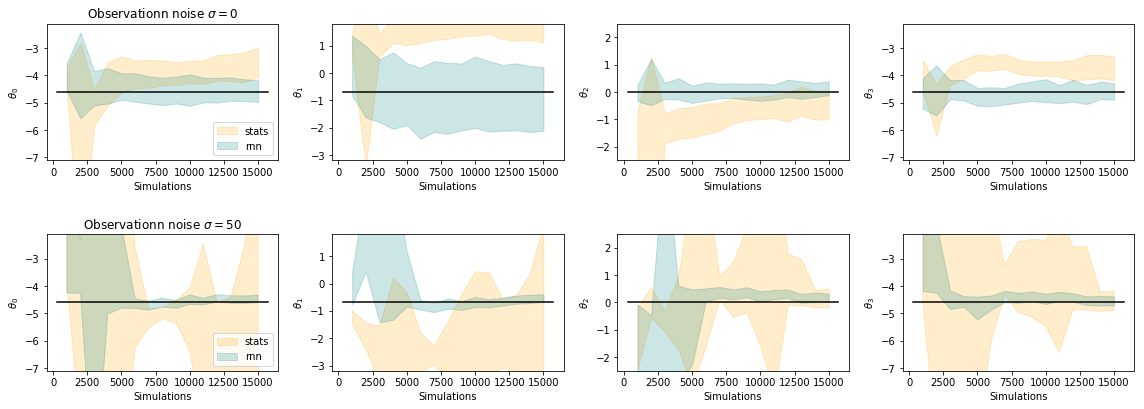

In [97]:
alpha = 0.2
rnn_color = 'teal'
stats_color='orange'

dim_param = pars_true.size
figh = plt.figure(figsize=(16,6))
for k in range(dim_param):
    ax = plt.subplot(2, dim_param, k+1)    
    for i, pps in enumerate(allp_stats):
        nsamples = run_opts['n_train'] * (1.0 + np.arange(len(pps)))
        hstats = plot_gaussian_sequence(nsamples, pps, color=stats_color, alpha=alpha, label='stats')
    for i, pps in enumerate(allp_rnn):
        nsamples = run_opts['n_train'] * (1.0 + np.arange(len(pps)))
        hrnn = plot_gaussian_sequence(nsamples, pps, color=rnn_color, alpha=alpha, label='rnn')
    plt.plot(plt.xlim(), np.ones(2) * pars_true[k],'k')
    plt.ylim(pars_true[k] + np.array([-1., 1.]) * 2.5)
    #plt.xlim([0, 10000])
    plt.xlabel('Simulations')
    plt.ylabel('$\\theta_{0}$'.format(k))
    ax.set_aspect(2000.)
    if k == 0:
        plt.legend(loc='lower right')
        plt.title('Observationn noise $\\sigma = 0$')

    ax = plt.subplot(2, dim_param, k+1 + dim_param)    
    for i, pps in enumerate(allp_stats_noise):
        nsamples = run_opts['n_train'] * (1.0 + np.arange(len(pps)))
        hstats = plot_gaussian_sequence(nsamples, pps, color=stats_color, alpha=alpha, label='stats')
    for i, pps in enumerate(allp_rnn_noise):
        nsamples = run_opts['n_train'] * (1.0 + np.arange(len(pps)))
        hrnn = plot_gaussian_sequence(nsamples, pps, color=rnn_color, alpha=alpha, label='rnn')
    plt.plot(plt.xlim(), np.ones(2) * pars_true[k],'k')
    plt.ylim(pars_true[k] + np.array([-1., 1.]) * 2.5)
    #plt.xlim([0, 10000])
    plt.xlabel('Simulations')
    plt.ylabel('$\\theta_{0}$'.format(k))
    ax.set_aspect(2000.)
    if k == 0:
        plt.legend(loc='lower right')
        plt.title('Observationn noise $\\sigma = 50$')
figh.tight_layout()

figh.savefig('rnn.pdf')

In [ ]:
plt.figure()
for i, ps in enumerate(allp):
    plt.plot(np.arange(len(ps)) + 1, [-pp.eval(pars_true.reshape(1, -1), log=True) for pp in ps])    
plt.ylim([-5, 20])

'auto'

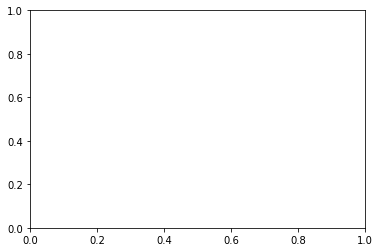

In [46]:
figh = plt.figure()
ax = plt.gca()
ax.get_aspect()

In [28]:
run_opts

{'n_train': 1000,
 'n_rounds': 10,
 'minibatch': 100,
 'epochs': [2000, 1000, 666, 500, 400, 333, 285, 250, 222, 200],
 'moo': 'resample',
 'proposal': 'gaussian',
 'n_null': None,
 'train_on_all': True,
 'max_norm': 0.1,
 'val_frac': 0.1,
 'silent_fail': False,
 'reuse_prior_samples': True}

In [20]:
import os
save_path

In [ ]:
# run with stats, including the first time point so rejection rate is very low
setup_opts_stats = deepcopy(setup_opts)
setup_opts_stats['n_rnn'] = 0

def init_all_stats(seed, n_steps_used=(raw_data.shape[0] - 2)// 2):
    assert (n_steps_used + int(include_initial_state)) * 2 <= raw_data.shape[0]
    model = LotkaVolterra(dt=dt, duration=dt * n_steps_used, seed=seed, noise_sd=noise_sd)
    prior = dd.Uniform(lower= [-5,-5,-5,-5], upper = [2,2,2,2], seed=seed)
    summary = LotkaVolterraStats(seed=seed)
    g = StubbornGenerator(model=model, prior=prior, summary=summary, seed=seed)
    
    if use_maf:
        setup_opts['rng'].seed(seed)
    # initialize inference object
    ii_max = n_steps_used + 1 if include_initial_state else n_steps_used
    obs_stats = summary.calc([dict(data=obs[:ii_max * 2])])
    res = infer.SNPEC(g, obs=obs_stats, seed=seed, **setup_opts_stats)
    return g, res

In [ ]:
L, TD, P = [], [], []

for i in range(n_seeds):
    seed = base_seed + i
    exp_id_stats = 'stats_fc_noise_seed' + str(seed)
    
    g, res = init_all_stats(seed=seed)
    # train
    t = timeit.time.time()
    logs, tds, posteriors = res.run(**run_opts, verbose=False)
    L.append(logs)
    TD.append(tds)
    P.append(posteriors)
    print('fitting time for data length {0}: '.format(dl), timeit.time.time() - t)
    
    save_results_byname(logs=L, tds=TD, posteriors=P, raw_data=raw_data,
                        setup_opts=setup_opts_stats, run_opts=run_opts, exp_id=exp_id_stats, path=save_path)

L_stats, TD_stats, P_stats = L, TD, P

# Load the data and plot

In [ ]:
pstats, Vstats = load_results_byname(exp_id=exp_id_stats, path=save_path)
L_stats = Vstats['logs']
del Vstats

pnostats, Vnostats = load_results_byname(exp_id=exp_id_nostats, path=save_path)
L_nostats = Vnostats['logs']
del Vnostats

dim_param = pstats[0][0].ndim
Ts = np.array(data_lengths, dtype=float) * dt
nsamples = run_opts['n_train'] * (np.arange(run_opts['n_rounds']) + 1)

In [ ]:
for k in range(dim_param):
    _ = plt.figure()
    iround = 3
    means_stats = np.array([P[iround].xs[0].m[k] for P in pstats])
    sds_stats = np.array([np.sqrt(P[iround].xs[0].S[k, k]) for P in pstats])
    means_nostats = np.array([P[iround].xs[0].m[k] for P in pnostats])
    sds_nostats = np.array([np.sqrt(P[iround].xs[0].S[k, k]) for P in pnostats])
    plt.plot(Ts, means_stats, 'b')
    plt.plot(Ts, means_stats + sds_stats, 'b:')
    plt.plot(Ts, means_stats - sds_stats, 'b:')
    plt.plot(Ts, means_nostats, 'g')
    plt.plot(Ts, means_nostats + sds_nostats, 'g:')
    plt.plot(Ts, means_nostats - sds_nostats, 'g:')
    plt.plot(plt.xlim(), np.ones(2) * pars_true[k],'k')
    plt.ylim(pars_true[k] + np.array([-1., 1.]) * .5)
        

In [ ]:
for k in range(dim_param):
    _ = plt.figure()
    for i, dl in enumerate(data_lengths):
        means = np.array([pp.xs[0].m[k] for pp in pstats[i]])
        sds = np.array([np.sqrt(pp.xs[0].S[k, k]) for pp in pstats[i]])
        _ = plt.plot(nsamples, means,
                     label='T = {0}'.format(Ts[i]))
    plt.legend()
    plt.plot(plt.xlim(), np.ones(2) * pars_true[k],'k')
    plt.xlim([0, 5000])

In [ ]:
h = []
for i, dl in enumerate(data_lengths):
    h.append(plt.plot(np.arange(len(L[i])) + 1,
                      [-pp.eval(pars_true.reshape(1, -1), log=True) for pp in P[i]],
                     label='T = {0}'.format(dl * dt))[0])
plt.legend(h)

In [ ]:
data_lengths = [5, 10, 25, 60, 100, 150]
plt.semilogx(data_lengths, np.ones_like(data_lengths),'.')

In [ ]:
np.diag(P[-1][-1].xs[0].S)

In [ ]:
ii=-1
posteriors_C = P[ii]
for r in range(len(posteriors_C)):
    
    posterior_C = posteriors_C[r]
    #posterior_C.ndim = posterior_A.ndim
    
    g2 = deepcopy(g)
    g2.proposal = posterior_C
    samples = np.array(g2.draw_params(5000)) 
    
    fig,_ = plot_pdf(dd.Gaussian(m=0.00000123*np.ones(pars_true.size), S=1e-30*np.eye(pars_true.size)), 
                   samples=samples.T,
                   gt=pars_true, 
                   lims=[[-5,2],[-5,2],[-5,2],[-5,2]],
                   #lims=[0,10],
                   resolution=100,
                   ticks=True,
                   figsize=(16,16));
    
    fig.suptitle('SNPE-C posterior estimates, round r = '+str(r+1), fontsize=14)
        

In [ ]:
plt.figure()
plt.plot(np.arange(len(posteriors_C)) + 1, [-posterior_C.eval(pars_true.reshape(1, -1), log=True) for posterior_C in posteriors_C])
plt.ylabel('-log p of true params')
plt.xlabel('round')